In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [4]:
from heapq import heappush, heappop

In [21]:
def get_filename(idx, folder='img_align_celeba/'):
    idstr = str(idx + 1)
    fid = ''.join(['0'] * (6 - len(idstr)) + [idstr])
    return ''.join([folder, fid, '.jpg'])

def get_cosine_scores(sample, embeddings):
    samplen = np.sqrt((sample ** 2).sum())
    embn = np.sqrt((embeddings ** 2).sum(axis=1))
    return 1 - embeddings.dot(sample) / (embn * samplen)

def get_euclidean_scores(sample, embeddings):
    if len(embeddings.shape) == 2:
        return np.sqrt(((embeddings - sample) ** 2).sum(axis=1))
    return np.sqrt(((embeddings - sample) ** 2).sum())

def get_nn_brute(emb, embeddings, n_neighbors):
    scores = get_euclidean_scores(emb, embeddings)
    args = np.argsort(scores)
    return args[:n_neighbors]

def norm(vect):
    return np.sqrt((vect ** 2).sum())

def get_distance(left, right, emb):
    embvec = emb - left
    rightvec = right - left
    norm_embvec = norm(embvec)
    norm_rightvec = norm(rightvec)
    cosalpha = (embvec * rightvec).sum() / (norm_embvec * norm_rightvec)
    leftdist = norm_embvec * cosalpha - 0.5 * norm_rightvec
    return leftdist

In [22]:
get_distances(np.array([0, 0]), np.array([2, 0]), np.array([0, 2]))

-1.0

In [31]:
embeddings = pickle.load(open('embeddings', 'rb'))

In [13]:
SIZE = len(embeddings)

In [14]:
p1 = embeddings[np.random.randint(0, SIZE)] #np.random.randn(128)
p2 = embeddings[np.random.randint(0, SIZE)] #p2 = np.random.randn(128)

In [15]:
mask = ((get_euclidean_scores(p1, embeddings) - get_euclidean_scores(p2, embeddings)) > 0)

In [16]:
mask.sum()

108420

In [14]:

class TreeNode():
    def __init__(self):
        self.left = None
        self.right = None
        self.left_point = None
        self.right_point = None
        self.emb_ids = None
        self.dist_value = None
        
    def get_nodes(self, emb, embeddings):
        dist = get_distance(embeddings[self.left_point], embeddings[self.right_point], emb)
        left_distance, right_distance = dist, -dist
        self.left.dist_value = left_distance
        self.right.dist_value = right_distance
        return self.left, self.right
    
    def __lt__(self, other):
        # print(self, other)
        if self.dist_value < other.dist_value:
            return True
        if self.dist_value > other.dist_value:
            return False
        if self.emb_ids is not None:
            return True
        if other.emb_ids is not None:
            return False
        return True
    
    def __str__(self):
        if self.emb_ids is None:
            return 'node: {}, {}'.format(self.left_point, self.right_point)
        return 'node embeddings: {}'.format(len(self.emb_ids))
    
    def __repr__(self):
        return str(self)
    

class AnnoyTree():
    def __init__(self, node_size = 100):
        self.root = None
        self.node_size = node_size
        self.embeddings = None
        self.kmeans_iter = 2
        
    def fit(self, embeddings):
        self.embeddings = embeddings
        self.root = TreeNode()
        self._rec_build(np.arange(len(embeddings)), self.root)
        
    def split(self, ids):
        left = 0
        right = 0
        while left == right:
            left = np.random.randint(0, len(ids))
            right = np.random.randint(0, len(ids))
        mask = ((get_euclidean_scores(self.embeddings[ids[left]], self.embeddings[ids]) -
                 get_euclidean_scores(self.embeddings[ids[right]], self.embeddings[ids])) > 0)
        left_ids = ids[mask==False]
        right_ids = ids[mask==True]
        return ids[left], ids[right], left_ids, right_ids
        
        return ids[left], ids[right], left_ids, right_ids
    
    def _rec_build(self, ids, node):
        if len(ids) < self.node_size:
            node.emb_ids = ids
            return
        left, right, left_ids, right_ids = self.split(ids)
        node.left_point = left
        node.right_point = right
        node.left = TreeNode()
        node.right = TreeNode()
        self._rec_build(left_ids, node.left)
        self._rec_build(right_ids, node.right)
        
    def _get_nearest(self, emb, node):
        if node.emb_ids is not None:
            scores = get_euclidean_scores(emb, self.embeddings[node.emb_ids])
            arg = np.argsort(scores)
            return node.emb_ids[arg]
        left_distance = get_euclidean_scores(self.embeddings[node.left_point], emb)
        right_distance = get_euclidean_scores(self.embeddings[node.right_point], emb)
        if left_distance < right_distance:
            return self._get_nearest(emb, node.left)
        return self._get_nearest(emb, node.right)
    
    def get_nearest(self, emb):
        return self._get_nearest(emb, self.root)

In [15]:
class AnnoyForest():
    def __init__(self, n_trees=5, node_size=100):
        self.n_trees = n_trees
        self.node_size = node_size
        self.trees = [AnnoyTree(node_size) for _ in range(n_trees)]
        self.embeddings = None
        
    def fit(self, embeddings):
        self.embeddings = embeddings
        for tree in self.trees:
            tree.fit(embeddings)
            
    def get_nearest(self, emb, n_neighbors):
        heap = []
        neighbors = set()
        for tree in self.trees:
            for node in tree.root.get_nodes(emb, self.embeddings):
                heappush(heap, node)
        while len(neighbors) < n_neighbors:
            if not heap:
                break
            node =heap[0]
            heappop(heap)
            if node.emb_ids is not None:
                neighbors.update(node.emb_ids)
            else:
                for child in node.get_nodes(emb, self.embeddings):
                        # print(child, end='\n')
                    heappush(heap, child)
        neighbors = np.array(list(neighbors))
        scores = get_euclidean_scores(emb, self.embeddings[neighbors])
        args = np.argsort(scores)
        return neighbors[args]
        

In [50]:
forest = AnnoyForest(node_size = 50, n_trees=10)
forest.fit(embeddings)

In [51]:
num = np.random.randint(0, len(embeddings))
num

155636

In [52]:
get_nn_brute(embeddings[num], embeddings, 10)

array([155636,  54590, 126531,  20607, 111737, 106326, 178816, 102818,
       105828,  93175])

In [54]:
forest.get_nearest(embeddings[num], 500)[:10]

array([155636, 126531,  20607, 106326, 102818, 173288,  39221,  91663,
       194653, 176154])

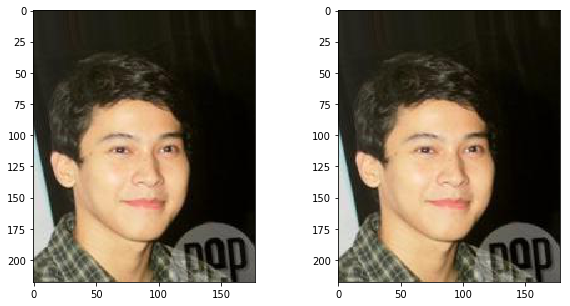

In [49]:
num = np.random.randint(0, len(embeddings))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(io.imread(get_filename(num)))
idn = forest.get_nearest(embeddings[num],1)[0]
ax[1].imshow(io.imread(get_filename(idn)))

In [81]:
t0 = time.time()
for _ in range(1000):
    num = np.random.randint(0, len(embeddings))
    idn = get_nn_brute(embeddings[num], embeddings)
print(time.time() - t0)

37.711671352386475


In [95]:
t0 = time.time()
for _ in range(1000):
    num = np.random.randint(0, len(embeddings))
    idn = tre.get_nearest(embeddings[num])
print(time.time() - t0)

0.34705471992492676


In [12]:
X = np.random.uniform(-1, 1, 1000).reshape((500, 2))

In [16]:
forest = AnnoyForest(node_size = 10, n_trees=1)
forest.fit(X)

In [17]:
X[0]

array([ 0.72197038, -0.74170858])

In [28]:
n1 = X[forest.trees[0].get_nearest(X[0])]
n2 = X[forest.get_nearest(X[0], 50)]
# n3 = X[forest.trees[2].get_nearest(X[0])]

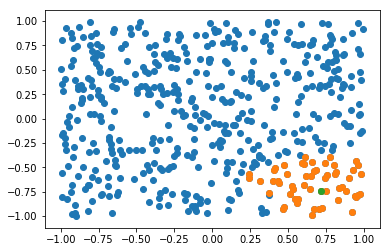

In [29]:
plt.scatter(X[:, 0], X[:, 1])

#plt.scatter(n1[:, 0], n1[:, 1])
plt.scatter(n2[:, 0], n2[:, 1])
# plt.scatter(n3[:, 0], n3[:, 1])
plt.scatter(X[0, 0], X[0 ,1])

In [310]:
nf = forest.get_nearest(X[0], 5)

In [311]:
scores = get_euclidean_scores(X[0], X)
arg = np.argsort(scores)
arg[:10]

array([  0, 410, 395,  54, 197,  21, 329, 363,  91, 133])

In [312]:
nf

array([  0, 410, 395,  54, 197,  21, 329, 363,  91, 133, 219, 168, 143,
       141,  26, 199, 314, 128, 364,  50, 409, 451, 307, 208, 446, 376,
       353, 400, 137])

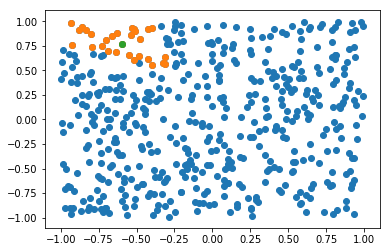

In [313]:
plt.scatter(X[:, 0], X[:, 1])

plt.scatter(X[nf][:, 0], X[nf][:, 1])
plt.scatter(X[0, 0], X[0 ,1])